In [1]:
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras import backend as K 

Using TensorFlow backend.
/Users/joanna/anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/joanna/anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/joanna/anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/joanna/anaconda2

In [2]:
img_width, img_height = 400, 400
  
train_data_dir = './Figaro1k/Original/Training'
validation_data_dir = './Figaro1k/Original/Testing'
nb_train_samples = 480 
nb_validation_samples = 120
epochs = 50
batch_size = 16

In [3]:
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [44]:

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [46]:
train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical') 
  
model.fit_generator( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size) 


Found 480 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Epoch 1/50
30/30 [==============================] - 54s 2s/step - loss: 2.0464 - accuracy: 0.2521 - val_loss: 1.3711 - val_accuracy: 0.2857
Epoch 2/50
30/30 [==============================] - 51s 2s/step - loss: 1.4020 - accuracy: 0.3042 - val_loss: 1.5842 - val_accuracy: 0.2308
Epoch 3/50
30/30 [==============================] - 50s 2s/step - loss: 1.3559 - accuracy: 0.3729 - val_loss: 1.3293 - val_accuracy: 0.3462
Epoch 4/50
30/30 [==============================] - 50s 2s/step - loss: 1.3001 - accuracy: 0.3938 - val_loss: 1.2932 - val_accuracy: 0.3654
Epoch 5/50
30/30 [==============================] - 50s 2s/step - loss: 1.3302 - accuracy: 0.4062 - val_loss: 1.3696 - val_accuracy: 0.2788
Epoch 6/50
30/30 [==============================] - 50s 2s/step - loss: 1.2740 - accuracy: 0.4062 - val_loss: 1.2542 - val_accuracy: 0.3654
Epoch 7/50
30/30 [==============================] - 50s 2s/step - loss: 1.2951

In [47]:
model.save_weights('model_masks_saved.h5') 

In [6]:
classes = train_generator.class_indices
print(classes)

NameError: name 'train_generator' is not defined

In [5]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image

In [7]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

#compile the 3-layer CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#load weights into new model
model.load_weights('model_saved.h5')


#GENERATE CONFUSION MATRIX, ITERATE OVER ALL TEST IMAGES
#path to folder where test images are located
path = './Figaro1k/Original/Testing/'
files = os.listdir(path)

y_true = [] #list of ground truth labels, will be plugged into sklearn confusion matrix
y_pred = [] #list of predicted labels
dict_labels = {0: 'curly', 1: 'kinky', 2: 'straight', 3: 'wavy'}

#iterate over every subfolder, and every image in each subfolder
#subfolders correspond to each class
for file in files:
    if os.path.isdir(os.path.join(path, file)):
        label_true = file #label all files in this folder as name of folder
        path_subfolder = path + file
        subfiles = os.listdir(path_subfolder) #list of all files in subfolder
        for subfile in subfiles:
            if subfile == '.DS_Store':
                continue
            img_path = os.path.join(path_subfolder, subfile)
            #load image
            img = image.load_img(img_path, target_size = (img_width, img_height))
            img_tensor = image.img_to_array(img)
            img_tensor = np.expand_dims(img_tensor, axis=0)
            img_tensor /= 255

            pred = model.predict(img_tensor) #make prediction
            label_pred = dict_labels[np.argmax(pred[0])]

            y_true.append(label_true) #append true label
            y_pred.append(label_pred) #append predicted label


#generate, print the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['curly','kinky','straight', 'wavy'])
print(cm)

[[12  5  3 10]
 [ 5 19  2  4]
 [ 1  5 13 11]
 [ 7  4  6 13]]


In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
print(np.flipud(np.fliplr(cm)))

[[13  6  4  7]
 [11 13  5  1]
 [ 4  2 19  5]
 [10  3  5 12]]


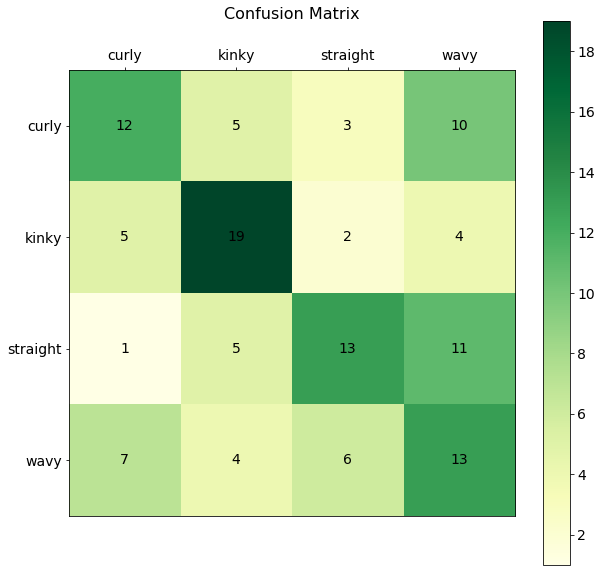

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
im=ax.imshow(cm[::-1], origin='upper', cmap='YlGn')
ax.set_title('Confusion Matrix', fontsize = 16, y =1.1)
for (j,i),label in np.ndenumerate(np.flipud(cm)):
    ax.text(i,j,label,ha='center',va='center', fontsize=14)
plt.xticks([0,1,2,3], ('curly', 'kinky', 'straight', 'wavy'), fontsize=14)
plt.yticks([0,1,2,3], ('wavy', 'straight', 'kinky', 'curly'), fontsize=14)
ax.set_ylim(-0.5, 3.5)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
cb = plt.colorbar(im)
cb.ax.tick_params(labelsize=14) 
plt.savefig('confusion_matrix.pdf')
plt.show()